In [1]:
import os
import sys
from pathlib import Path

path = Path(os.getcwd())
print(path)
module_path = str(path.parent) + '/'
sys.path.append(module_path)

C:\Users\themb\Sakhile\Jupyter_tutorial\PyMDP_Agent


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from pymdp import maths, utils
from pymdp.maths import spm_log_single as log_stable
from pymdp import control
print("imports loaded")

imports loaded


In [3]:
state_mapping = {0: (0, 0), 1: (2, 0), 2: (3, 0), 3: (4, 0), 4: (5, 0), 5: (6, 0), 6: (7, 0), 7: (8, 0), 8: (9, 0), 9: (0,1), 
                 10: (1, 1), 11: (2, 1), 12: (3, 1), 13: (4, 1), 14: (6, 1), 15: (7, 1), 16: (8, 1), 17: (9, 1), 18: (0, 2), 
                 19: (1, 2), 20: (2, 2), 21: (3, 2), 22: (4, 2), 23: (6, 2), 24: (7, 2), 25: (8, 2), 26: (9, 2), 27: (2, 3), 
                 28: (5, 3), 29: (7, 3), 30: (8, 3), 31: (9, 3), 32: (0, 4), 33: (1, 4), 34: (3, 4), 35: (5, 4), 36: (9, 4), 
                 37: (0, 5), 38: (1, 5), 39: (3, 5), 40: (5, 5), 41: (6, 5), 42: (7, 5), 43: (8, 5), 44: (9, 5), 45: (0, 6), 
                 46: (1, 6), 47: (2, 6), 48: (3, 6), 49: (4, 6), 50: (5, 6), 51: (6, 6), 52: (7, 6), 53: (8, 6), 54: (9, 6), 
                 55: (0, 7), 56: (1, 7), 57: (2, 7), 58: (3, 7), 59: (4, 7), 60: (5, 7), 61: (0, 8), 62: (6, 8), 63: (7, 8), 
                 64: (8, 8), 65: (9, 8), 66: (0, 9), 67: (1, 9), 68: (2, 9), 69: (3, 9), 70: (4, 9), 71: (5, 9), 72: (6, 9), 
                 73: (8, 9), 74: (9, 9)}

A = np.eye(75)
def plot_beliefs(Qs, title=""):
    fig = plt.figure(figsize = (20, 5))
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), Qs, color='r', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.title(title)
    plt.show()
    
labels = [state_mapping[i] for i in range(A.shape[1])]
def plot_likelihood(A):
    fig = plt.figure(figsize = (20,20))
    ax = sns.heatmap(A, xticklabels = labels, yticklabels = labels, cbar = False)
    plt.title("Likelihood distribution (A)")
    plt.show()
    
def plot_empirical_prior(B):
    fig, axes = plt.subplots(3,2, figsize=(8, 10))
    actions = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'STAY']
    count = 0
    for i in range(3):
        for j in range(2):
            if count >= 5:
                break
                
            g = sns.heatmap(B[:,:,count], cmap="OrRd", linewidth=2.5, cbar=False, ax=axes[i,j])

            g.set_title(actions[count])
            count += 1
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()
    
def plot_transition(B):
    fig, axes = plt.subplots(2,3, figsize = (20,20))
    a = list(actions.keys())
    count = 0
    for i in range(dim-1):
        for j in range(dim):
            if count >= 5:
                break 
            g = sns.heatmap(B[:,:,count], cmap = "OrRd", linewidth = 2.5, cbar = False, ax = axes[i,j], xticklabels=labels, yticklabels=labels)
            g.set_title(a[count])
            count +=1 
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()

<AxesSubplot:>

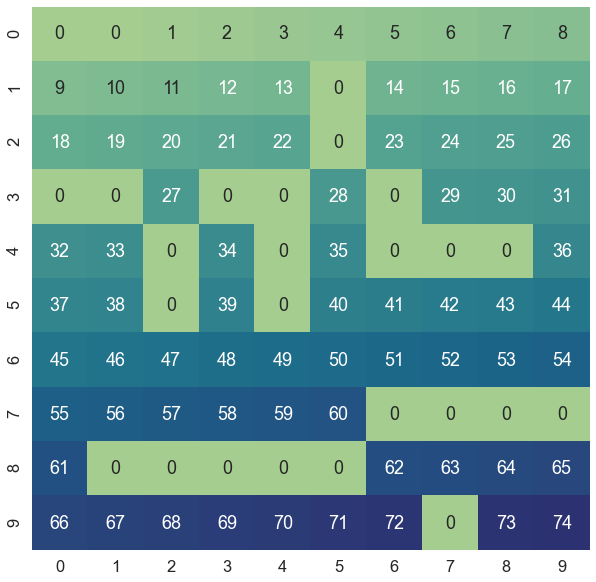

In [4]:
grid = np.zeros((10,10))
for linear_index, xy_coordinates in state_mapping.items():
    x, y = xy_coordinates
    grid[y,x] = linear_index
fig = plt.figure(figsize = (10,10))
sns.set(font_scale=1.5)
sns.heatmap(grid, annot=True,  cbar = False, fmt='.0f', cmap='crest')

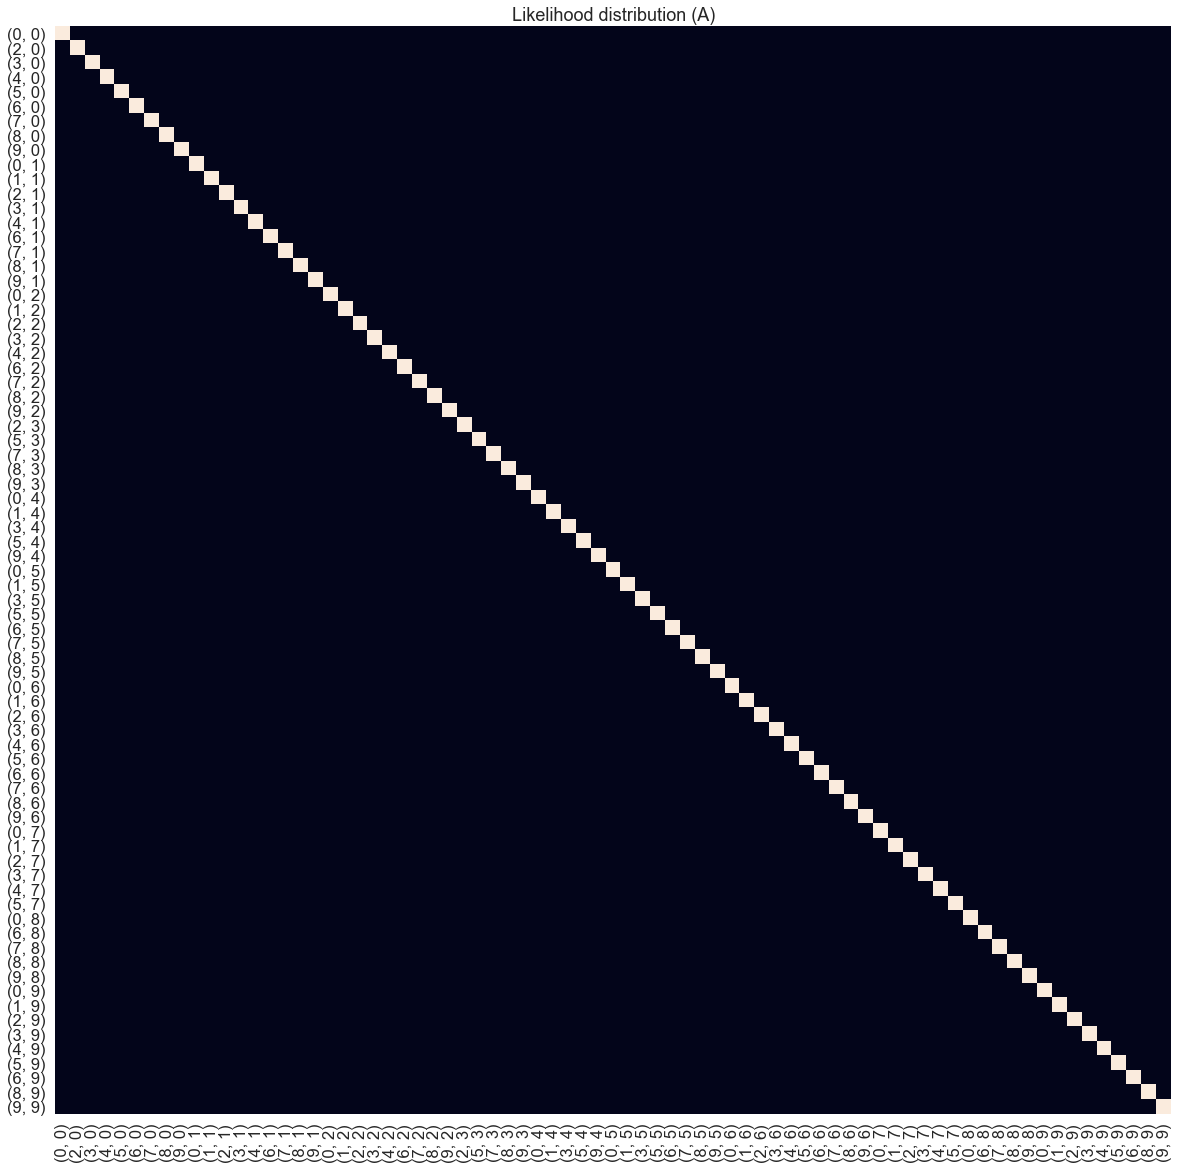

In [5]:
A = np.eye(75)
plot_likelihood(A)

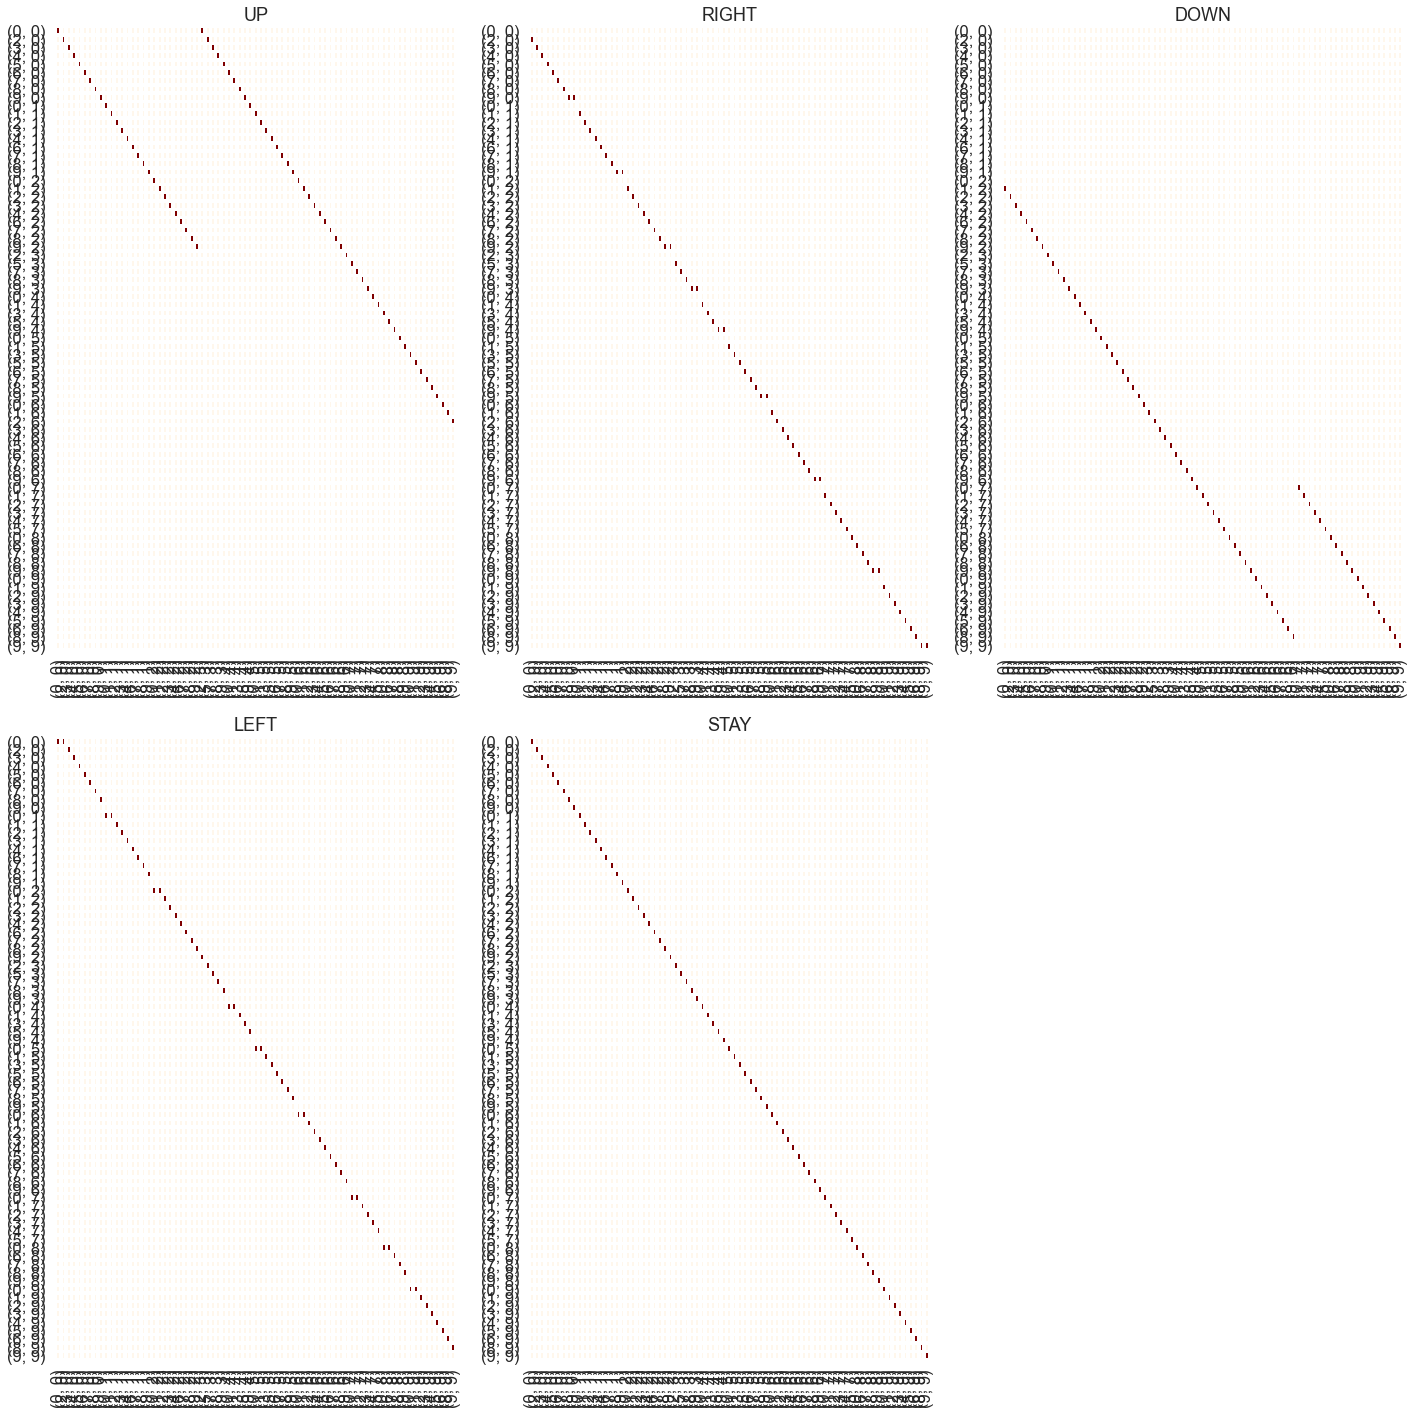

In [6]:
P = {}
dim = 3
gridDim = 10
actions = {'UP':0, 'RIGHT':1, 'DOWN':2, 'LEFT':3, 'STAY':4}

for state_index, xy_coordinates in state_mapping.items():
    P[state_index] = {a : [] for a in range(len(actions))}
    x, y = xy_coordinates

    
    P[state_index][actions['UP']] = state_index if (y >= 0 and y <= 2)  else state_index - 27 #dim 
    P[state_index][actions["RIGHT"]] = state_index if x == (gridDim -1) else state_index + 1
    P[state_index][actions['DOWN']] = state_index if (y >= 7 and y <= (gridDim -1)) else state_index + 19#dim
    P[state_index][actions['LEFT']] = state_index if x == 0 else state_index - 1
    P[state_index][actions['STAY']] = state_index

num_states = 75
B = np.zeros([num_states, num_states, len(actions)])
for s in range(num_states):
    for a in range(len(actions)):
        ns = int(P[s][a])
        B[ns, s, a] = 1

plot_transition(B)

In [11]:
class GridWorldEnv():
    
    def __init__(self,A,B):
        self.A = deepcopy(A)
        self.B = deepcopy(B)
        print("B:", B.shape)
        self.state = np.zeros(75)
        # start at state 3
        self.state[2] = 1
    
    def step(self,a):
        self.state = np.dot(self.B[:,:,a], self.state)
        obs = utils.sample(np.dot(self.A, self.state))
        return obs

    def reset(self):
        self.state =np.zeros(75)
        self.state[2] =1 
        obs = utils.sample(np.dot(self.A, self.state))
        return obs
    
env = GridWorldEnv(A,B)

B: (75, 75, 5)


In [12]:
def KL_divergence(q,p):
    return np.sum(q * (log_stable(q) - log_stable(p)))

In [13]:
def compute_free_energy(q,A, B):
    return np.sum(q * (log_stable(q) - log_stable(A) - log_stable(B)))

In [14]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def perform_inference(likelihood, prior):
    return softmax(log_stable(likelihood) + log_stable(prior))

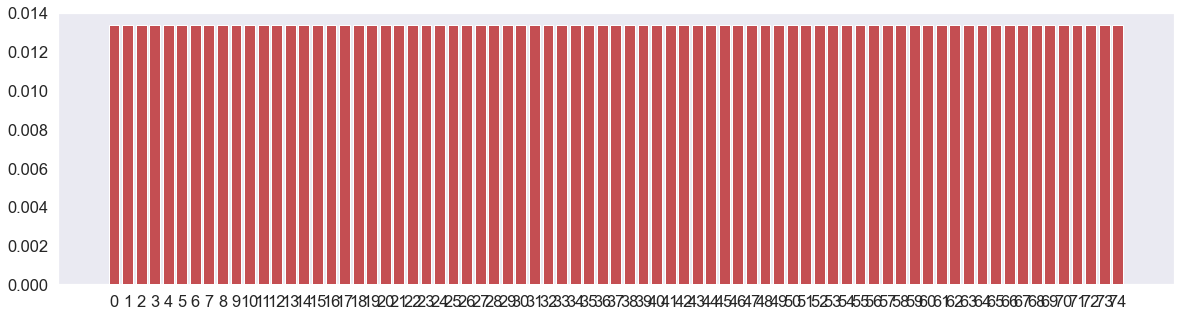

array([0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333

In [15]:
Qs = np.ones(75) *1/75
plot_beliefs(Qs)

(6, 0)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


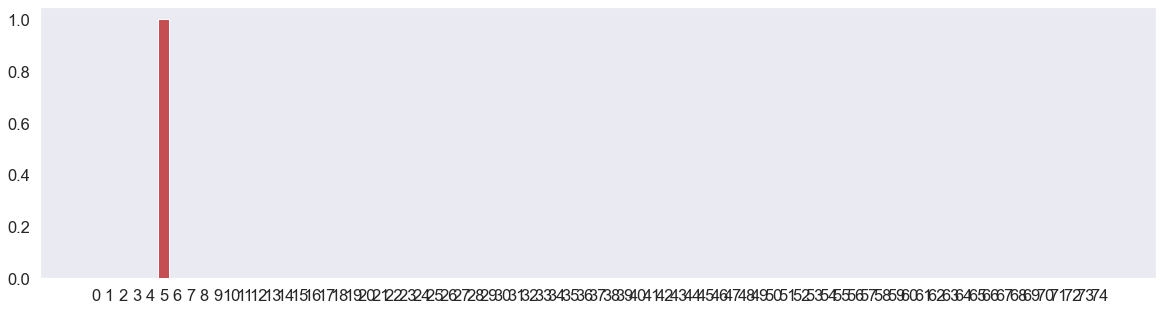

In [16]:
REWARD_LOCATION = 5
# REWARD_LOCATION1 = 25
# REWARD_LOCATION2 = 70
reward_state = state_mapping[REWARD_LOCATION]
print(reward_state)

C = np.zeros(num_states)
C[REWARD_LOCATION] = 1.
# C[REWARD_LOCATION1] = 1.
# C[REWARD_LOCATION2] = 1.
print(C)
plot_beliefs(C)

In [17]:
def evaluate_policy(policy, Qs, A, B, C):
    G = 0

    for t in range(len(policy)):
        u = int(policy[t])
        Qs_pi = B[:,:,u].dot(Qs)
        Qo_pi = A.dot(Qs_pi)
        H = - (A * log_stable(A)).sum(axis = 0)
        divergence = KL_divergence(Qo_pi, C)
        uncertainty = H.dot(Qs_pi)
        G += (divergence + uncertainty)

    return -G

In [18]:
def infer_action(Qs, A, B, C, n_actions, policies):
    neg_G = np.zeros(len(policies))

    for i, policy in enumerate(policies):
        neg_G[i] = evaluate_policy(policy, Qs, A, B, C)

    Q_pi = maths.softmax(neg_G)
    Qu = np.zeros(n_actions)

    for i, policy in enumerate(policies):
        u = int(policy[0])
        Qu[u] += Q_pi[i]

    utils.norm_dist(Qu)
    u = utils.sample(Qu)

    return u

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


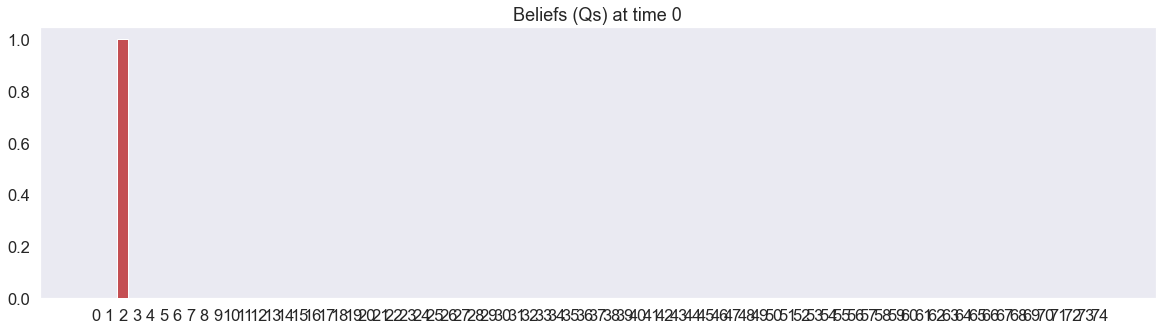

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


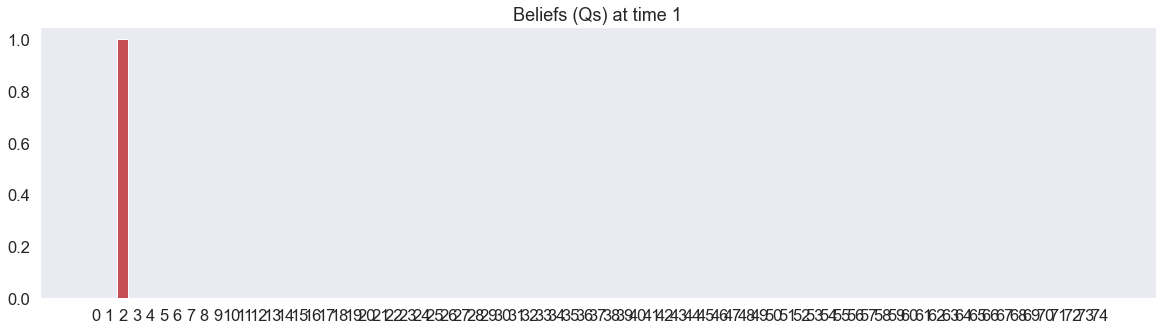

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


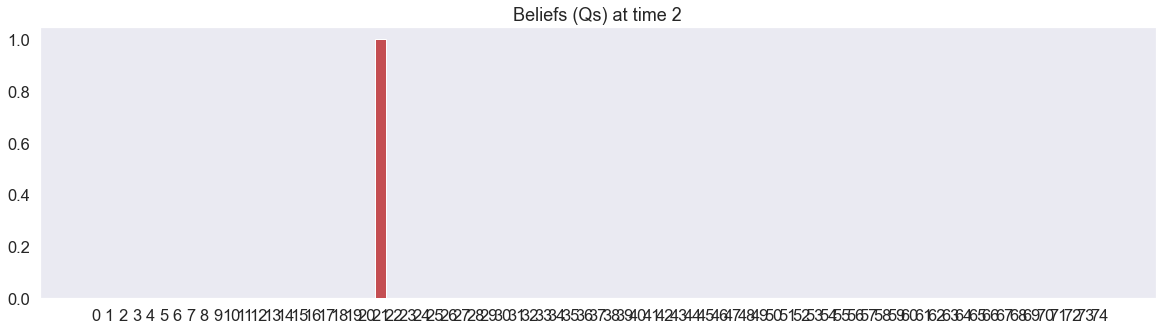

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


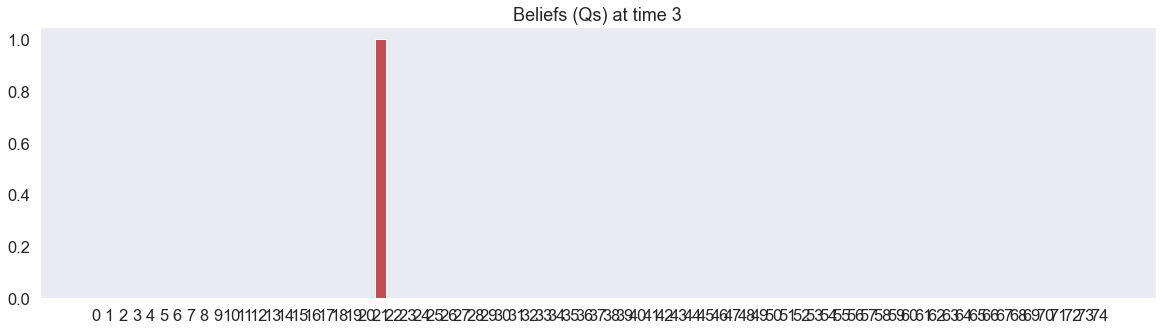

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


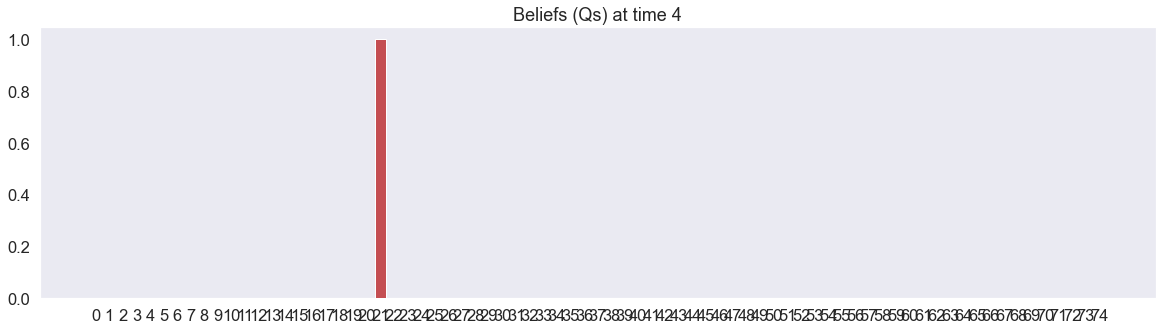

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


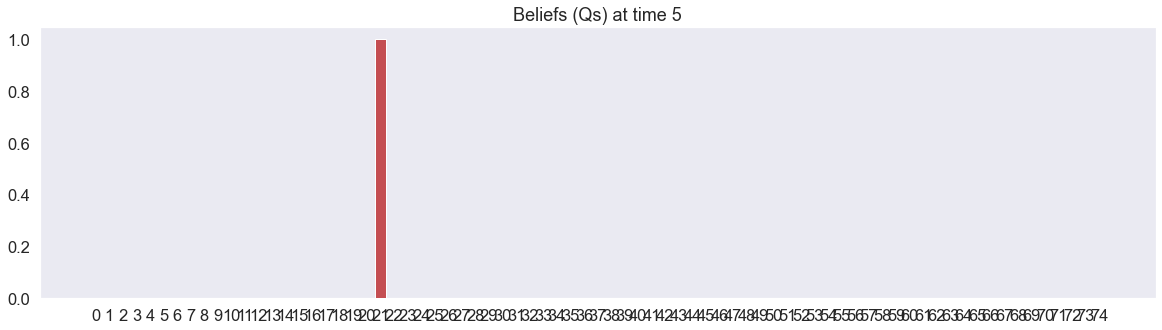

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


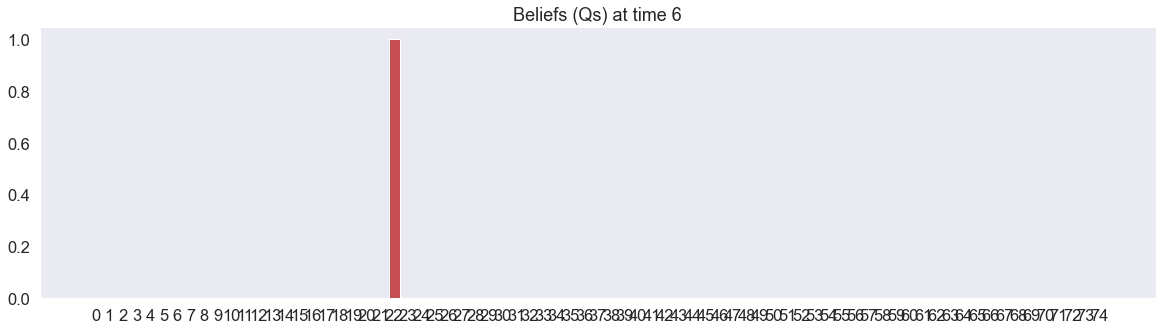

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


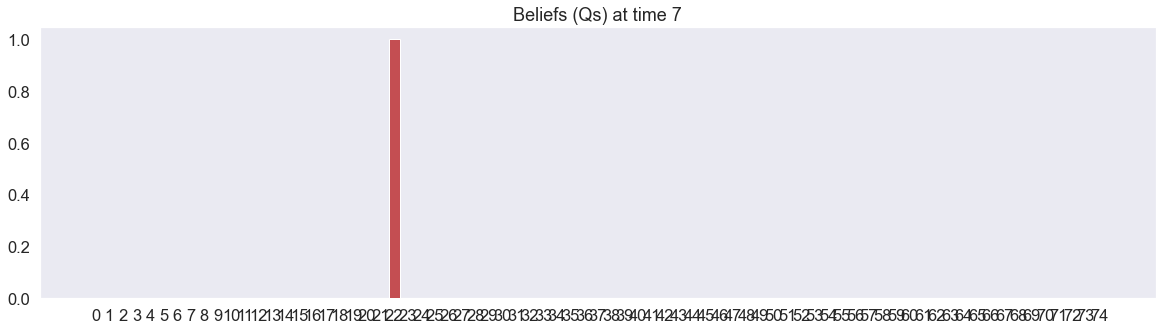

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


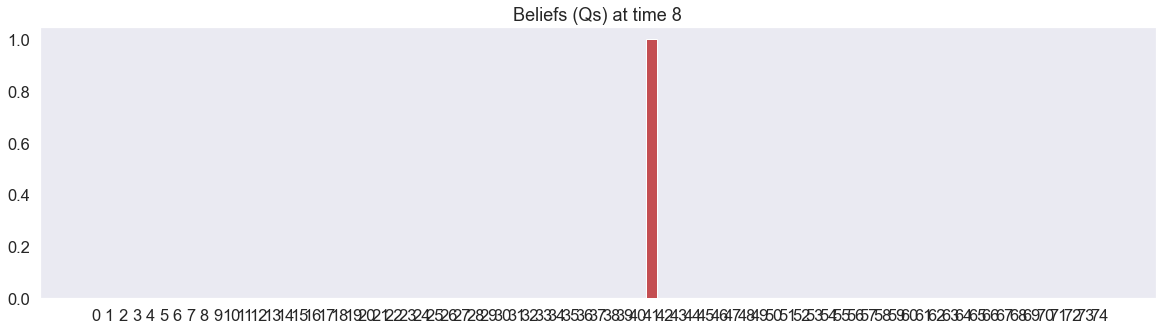

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


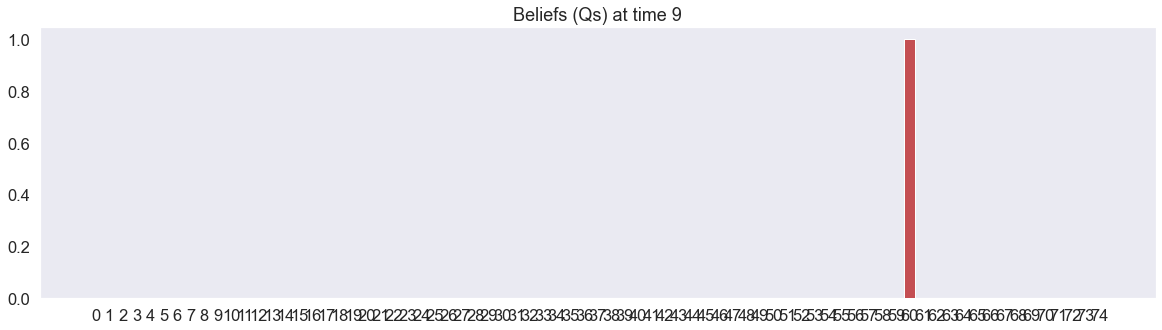

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


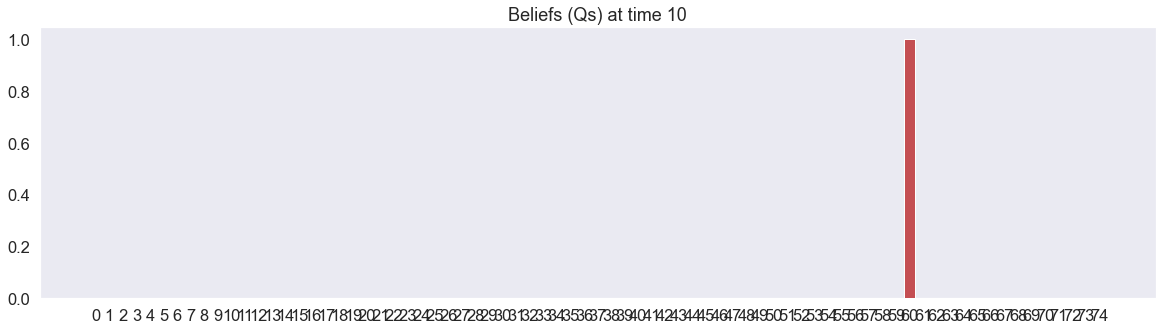

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


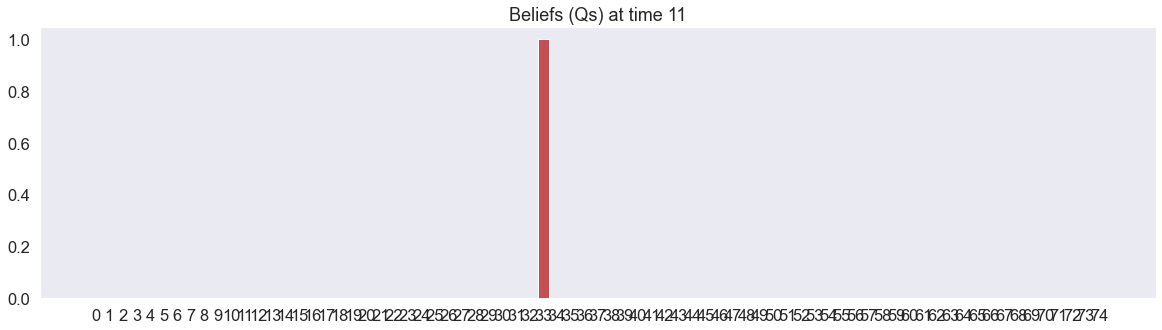

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


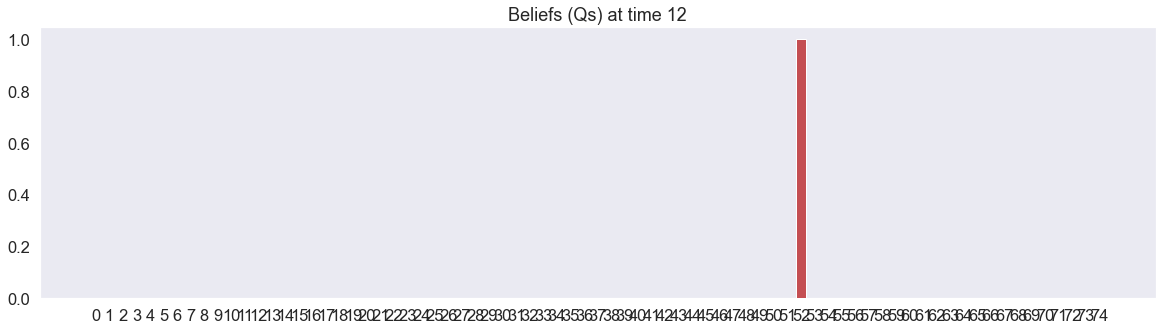

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


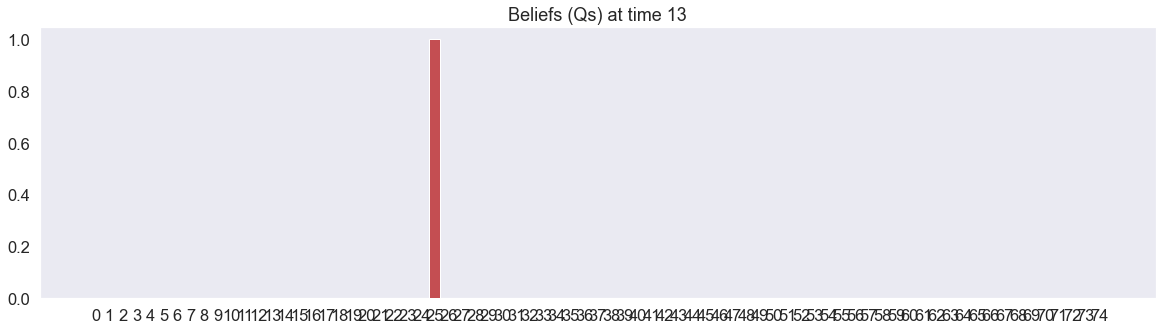

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


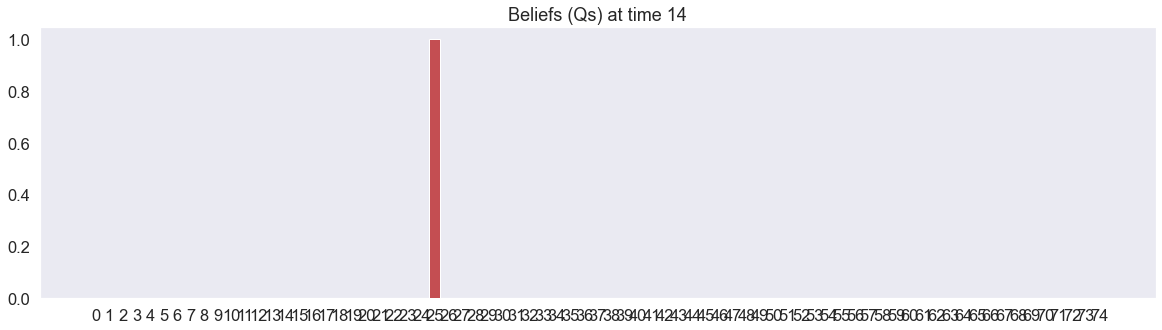

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


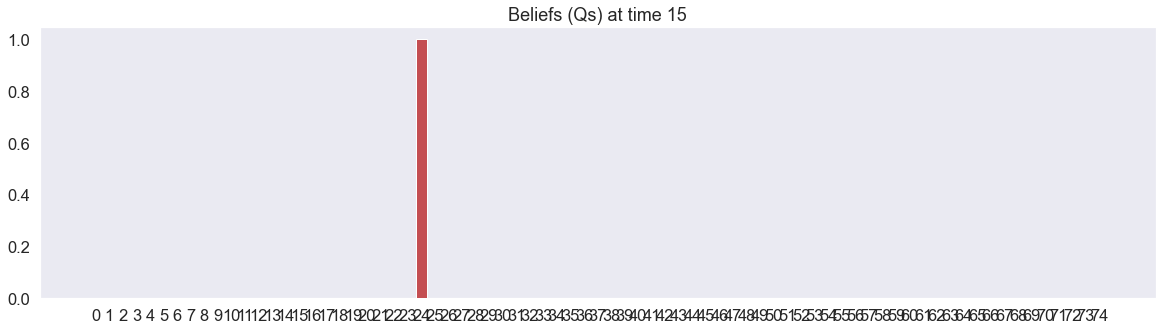

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


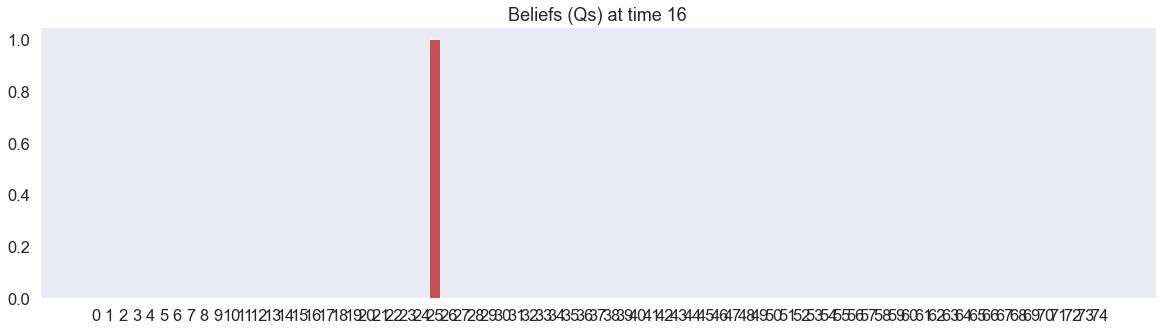

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


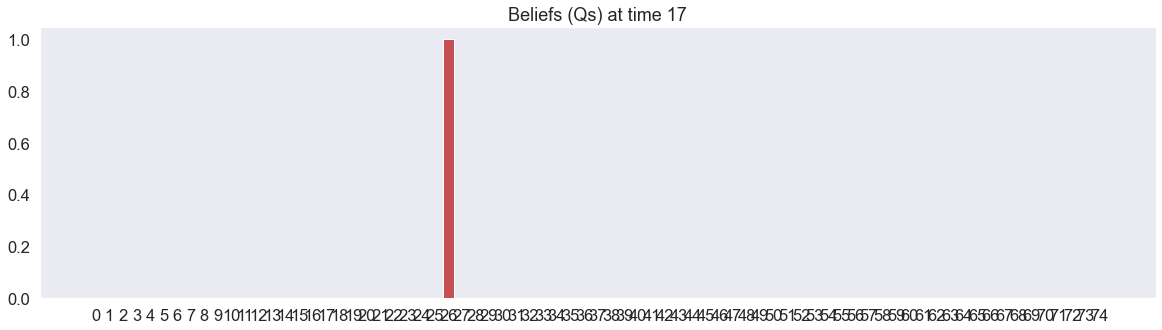

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


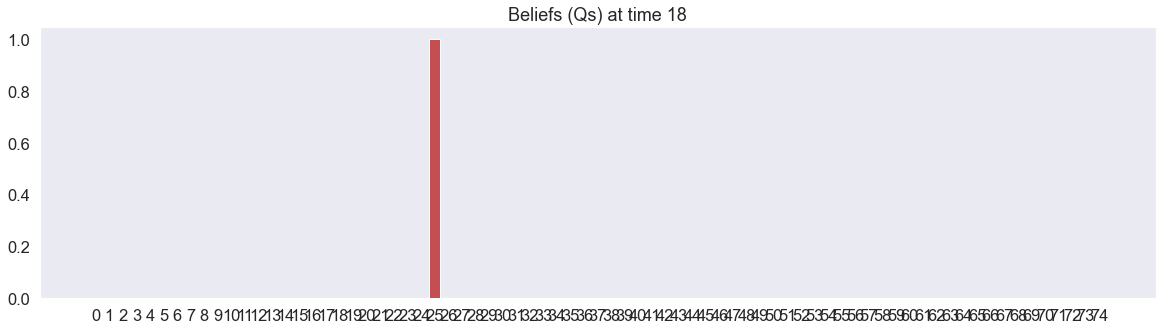

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


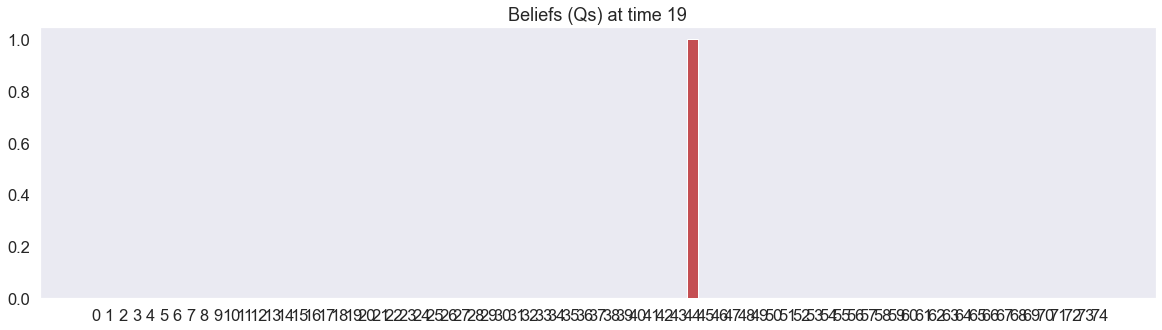

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [ ]:
T = 50
n_actions = 5
policy_len = 4

policies = control.construct_policies([B.shape[0]], [n_actions], policy_len)

o = env.reset()
for t in range(T):
    a = infer_action(Qs, A, B, C, n_actions, policies)
    o = env.step(int(a))
    likelihood = A[o,:]
    prior = B[:,:,int(a)].dot(Qs)
    Qs = maths.softmax(log_stable(likelihood) + log_stable(prior))
    print(Qs.round(3))
    plot_beliefs(Qs, "Beliefs (Qs) at time {}".format(t))